In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/My\ Drive/

 2019-10-31-130650.MP3			 fanta2018.docx
 2019-10-31-142238.MP3			'fisica 5 (1).pdf'
 2019-11-01-164342.MP3			'fisica 5.pdf'
 2019-11-01-210914.MP3			'FONDAMENTI DI AUTOMATICA.pdf'
 car					 Invoice-3188660640.pdf
 carte					 model.h5
'Cartella senza titolo'			 palestina.ppt
 cartesenzajoker.zip			 palestina.ppt.gslides
 carte.zip				'Parte 1.pdf'
'Colab Notebooks'			'Presentazione Africa.pptx'
'Come fare esercizi tde 2018.rtf.gdoc'	'Presentazione Africa.pptx.gslides'
'Copia di PROBABILITÀ.pdf'		'PROGRAMMA_di_LINGUA_e_CULTURA_INGLESE (1) (1).ODT.gdoc'
 CV.gdoc				'PROGRAMMA_di_LINGUA_e_CULTURA_INGLESE (1).ODT.gdoc'
 Dante.pdf				 PROGRAMMA_di_LINGUA_e_CULTURA_INGLESE.ODT.gdoc
'delega patrizia.pdf'


In [ ]:
!unzip /content/drive/My\ Drive/carte.zip -d /content/

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/train/jack of spades/059.jpg  
  inflating: /content/train/jack of spades/060.jpg  
  inflating: /content/train/jack of spades/061.jpg  
  inflating: /content/train/jack of spades/062.jpg  
  inflating: /content/train/jack of spades/063.jpg  
  inflating: /content/train/jack of spades/064.jpg  
  inflating: /content/train/jack of spades/065.jpg  
  inflating: /content/train/jack of spades/066.jpg  
  inflating: /content/train/jack of spades/067.jpg  
  inflating: /content/train/jack of spades/068.jpg  
  inflating: /content/train/jack of spades/069.jpg  
  inflating: /content/train/jack of spades/070.jpg  
  inflating: /content/train/jack of spades/071.jpg  
  inflating: /content/train/jack of spades/072.jpg  
  inflating: /content/train/jack of spades/073.jpg  
  inflating: /content/train/jack of spades/074.jpg  
  inflating: /content/train/jack of spades/075.jpg  
  inflating: /content/train/jack of spades/076.jp

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, RandomFlip, RandomRotation, RandomHeight, RandomWidth, RandomZoom, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import json
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap


In [ ]:
batch_size = 32
img_height = 224
img_width = 224
SEED = 37
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [13]:
#upload the training set

train_folder=r"/content/train"
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7624 files belonging to 53 classes.


In [14]:
#upload the validation set

valid_folder=r"/content/valid"
val_ds = tf.keras.utils.image_dataset_from_directory(
  valid_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 265 files belonging to 53 classes.


In [15]:
#upload the test set

test_folder=r"/content/test"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_folder,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 265 files belonging to 53 classes.


In [ ]:
class_names= train_ds.class_names

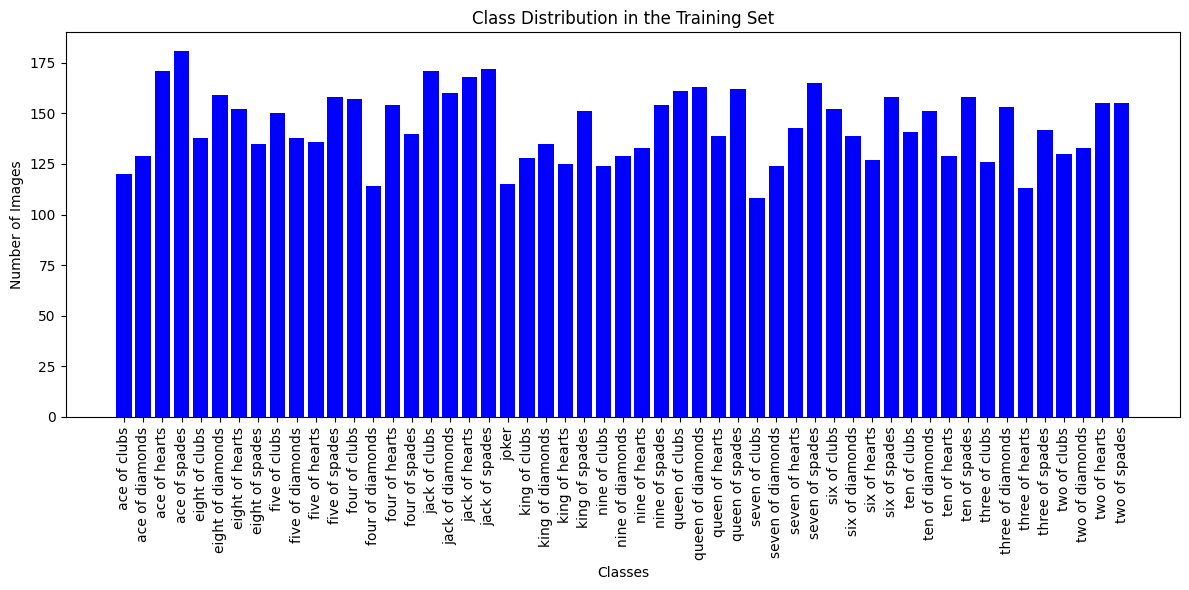

In [ ]:
#distribution in the training set

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
class_counts = {class_name: 0 for class_name in class_names}
for images, labels in train_ds:
    labels_np = labels.numpy()
    unique, counts = np.unique(labels_np, return_counts=True)

    for i in range(len(unique)):
        class_counts[class_names[unique[i]]] += counts[i]

plt.bar(class_counts.keys(), class_counts.values(), color='blue')  # Colore modificato a blu per differenziare
plt.xticks(rotation=90)
plt.title("Class Distribution in the Training Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.tight_layout()

plt.savefig('/content/traindistribution.png')
plt.show()

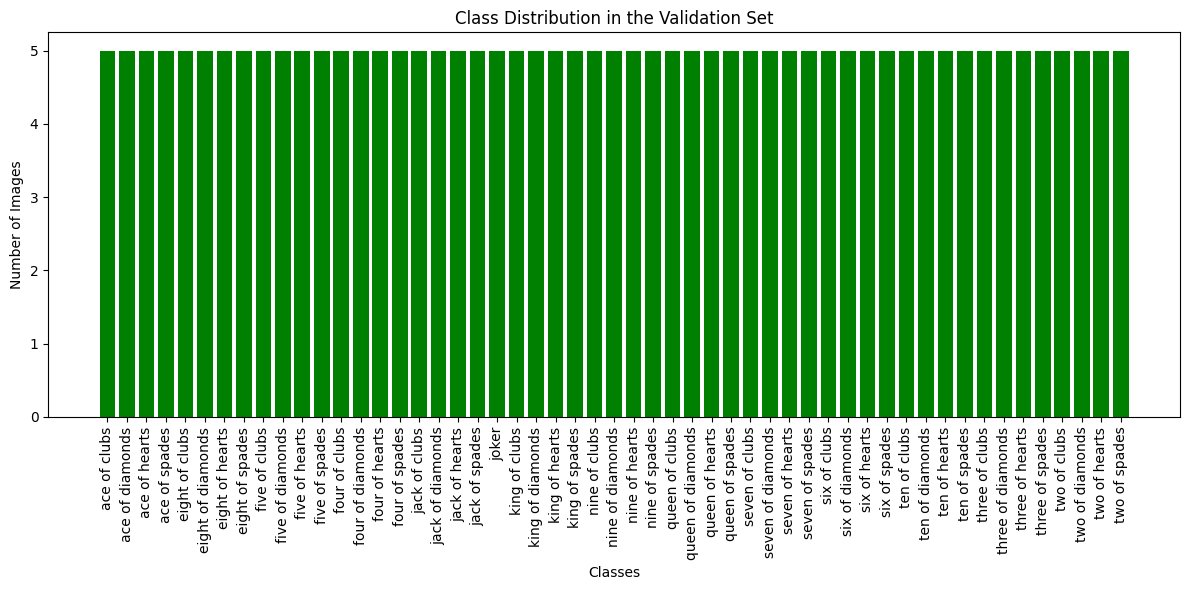

In [ ]:
#distribution in the validation set

plt.figure(figsize=(12, 6))

class_counts = {class_name: 0 for class_name in class_names}
for images, labels in val_ds:
    labels_np = labels.numpy()
    unique, counts = np.unique(labels_np, return_counts=True)

    for i in range(len(unique)):
        class_counts[class_names[unique[i]]] += counts[i]
plt.bar(class_counts.keys(), class_counts.values(), color='green')
plt.xticks(rotation=90)

plt.title("Class Distribution in the Validation Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.savefig('/content/validdistribution.png')
plt.show()

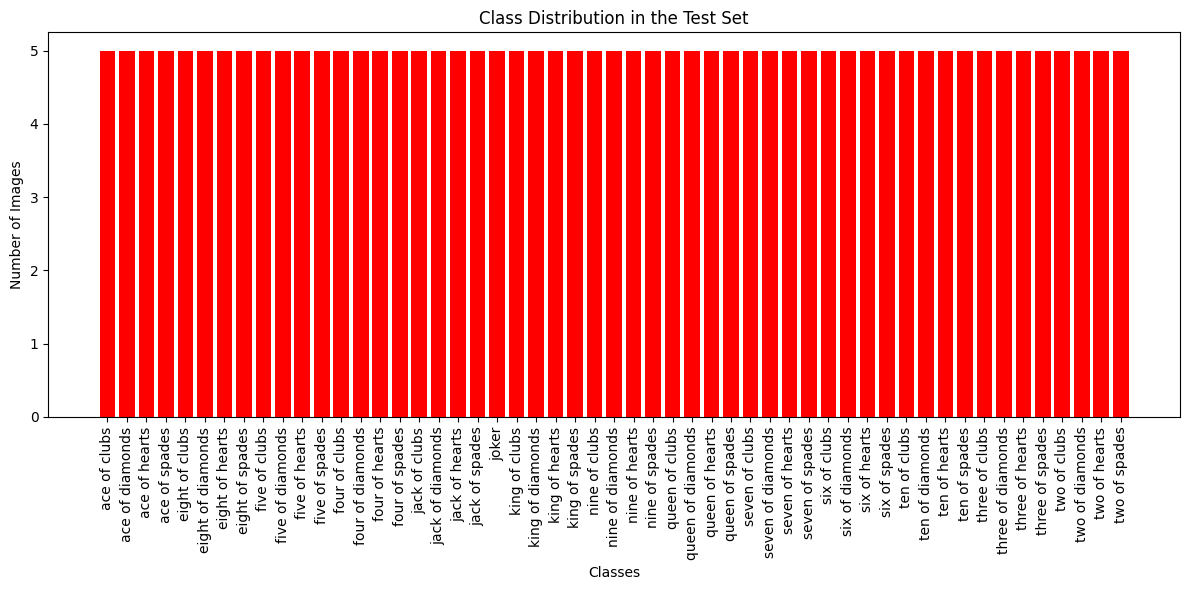

In [ ]:
#distribution in the test set

plt.figure(figsize=(12, 6))

class_counts = {class_name: 0 for class_name in class_names}
for images, labels in test_ds:
    labels_np = labels.numpy()
    unique, counts = np.unique(labels_np, return_counts=True)

    for i in range(len(unique)):
        class_counts[class_names[unique[i]]] += counts[i]
plt.bar(class_counts.keys(), class_counts.values(), color='red')
plt.xticks(rotation=90)
plt.title("Class Distribution in the Test Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.savefig('/content/test_distribution.png')
plt.show()

In [ ]:
#function for the average

def compute_average_color(images):
    avg_colors = []
    for img in images:
        avg_color = np.mean(img, axis=(0, 1))
        avg_colors.append(avg_color)
    return np.mean(avg_colors, axis=0)
class_images = {class_name: [] for class_name in class_names}
for images, labels in train_ds:
    labels_np = labels.numpy()
    for i in range(images.shape[0]):
        class_name = class_names[labels_np[i]]
        class_images[class_name].append(images[i].numpy())

avg_colors = {class_name: compute_average_color(class_images[class_name]) for class_name in class_names}

for class_name, color in avg_colors.items():
    print(f"Average color for {class_name}: {color}")

Average color for ace of clubs: [207.17612 205.11217 196.4468 ]
Average color for ace of diamonds: [217.10057 204.95146 196.93848]
Average color for ace of hearts: [203.75809 189.01543 184.73483]
Average color for ace of spades: [184.23082 178.79071 171.45747]
Average color for eight of clubs: [183.07826 178.62344 169.42085]
Average color for eight of diamonds: [204.02402 182.30992 174.2404 ]
Average color for eight of hearts: [210.43965 184.67995 176.75635]
Average color for eight of spades: [191.51433 188.14572 181.16174]
Average color for five of clubs: [198.13469 195.34375 188.11943]
Average color for five of diamonds: [211.94481 195.93425 188.20674]
Average color for five of hearts: [204.76567 184.49188 179.50934]
Average color for five of spades: [188.31923 187.95055 181.40308]
Average color for four of clubs: [195.39308 192.06342 184.2409 ]
Average color for four of diamonds: [213.93752 199.70546 192.3421 ]
Average color for four of hearts: [212.52429 193.84198 185.8451 ]
Averag

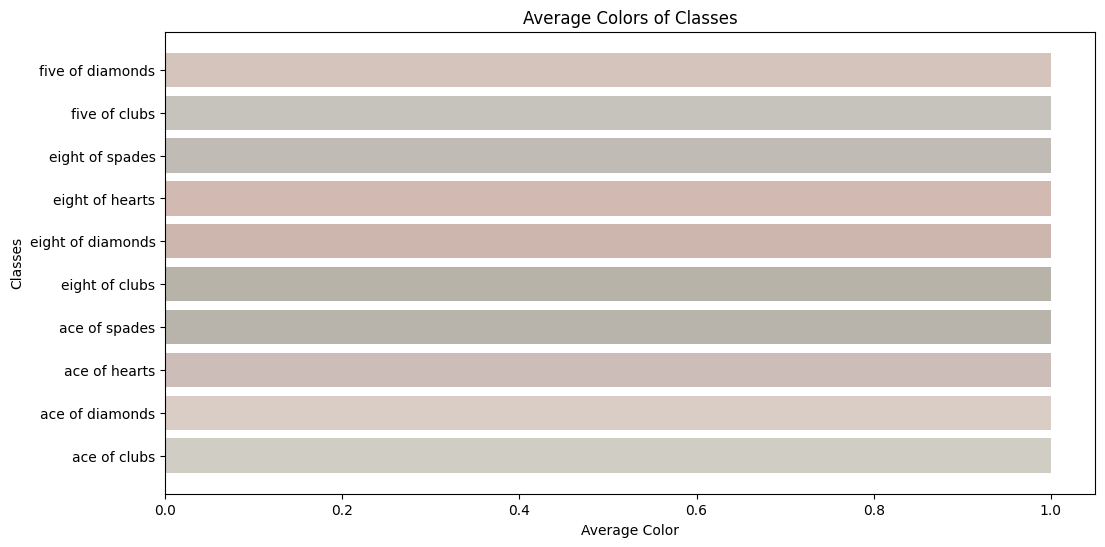

In [ ]:
#average color figure

avg_colors_values = np.array(list(avg_colors.values()))
avg_colors_normalized = avg_colors_values / 255.0

class_names= class_names[:10]

plt.figure(figsize=(12, 6))
plt.barh(class_names[:10], np.ones(len(class_names)), color=avg_colors_normalized)
plt.title("Average Colors of Classes")
plt.xlabel("Average Color")
plt.ylabel("Classes")
plt.savefig('/content/averagecolors.png')
plt.show()

In [9]:
#function for the detection of blurry images

def is_blurry(image_path, threshold=100):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return var < threshold, var

def remove_blurry_images(image_dir):
    removed_images = []
    for class_name in os.listdir(image_dir):
        class_path = os.path.join(image_dir, class_name)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                blurry, var = is_blurry(img_path)
                if blurry:
                    img_rimossa = cv2.imread(img_path)
                    os.remove(img_path)
                    removed_images.append(img_path)
                    plt.imshow(cv2.cvtColor(img_rimossa, cv2.COLOR_BGR2RGB))
                    plt.title(f"Removed Image - Laplacian Variance: {var:.2f}")
                    plt.axis('off')
                    plt.show()
                    output_dir = 'immagini_sfocate'
                    os.makedirs(output_dir, exist_ok=True)
                    output_path = os.path.join(output_dir, f'immagine_sfocata_{var:.2f}.png')
                    cv2.imwrite(output_path, img_rimossa)

    return removed_images

In [ ]:
#remove the blurry images from training set

image_directory = '/content/train'
removed_blurry_images = remove_blurry_images(image_directory)
print(f"{len(removed_blurry_images)} blurries images removed.")
def load_dataset(image_directory, img_height=img_height, img_width=img_width, batch_size=batch_size):
    return tf.keras.preprocessing.image_dataset_from_directory(
        image_directory,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
train_ds = load_dataset(image_directory)

Output hidden; open in https://colab.research.google.com to view.

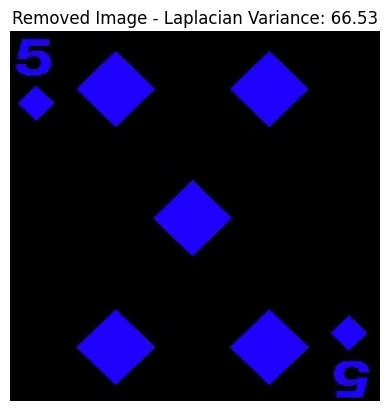

1 blurries images removed.
Found 264 files belonging to 53 classes.


In [ ]:
#remove the blurry images from validation set

image_directory_valid = '/content/valid'
removed_blurry_images = remove_blurry_images(image_directory_valid)
print(f"{len(removed_blurry_images)} blurries images removed.")
def load_dataset(image_directory, img_height=img_height, img_width=img_width, batch_size=batch_size):
    return tf.keras.preprocessing.image_dataset_from_directory(
        image_directory_valid,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
valid_ds = load_dataset(image_directory)

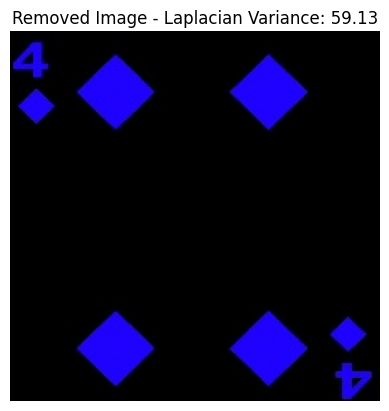

1 blurries images removed.
Found 264 files belonging to 53 classes.


In [ ]:
#remove the blurry images from test set

image_directory_test = '/content/test'
removed_blurry_images = remove_blurry_images(image_directory_test)
print(f"{len(removed_blurry_images)} blurries images removed.")
def load_dataset(image_directory, img_height=img_height, img_width=img_width, batch_size=batch_size):
    return tf.keras.preprocessing.image_dataset_from_directory(
        image_directory_test,
        image_size=(img_height, img_width),
        batch_size=batch_size
    )
test_ds = load_dataset(image_directory)

In [ ]:
label_to_class_name = dict(zip(range(len(train_ds.class_names)), train_ds.class_names))
label_to_class_name

{0: 'ace of clubs',
 1: 'ace of diamonds',
 2: 'ace of hearts',
 3: 'ace of spades',
 4: 'eight of clubs',
 5: 'eight of diamonds',
 6: 'eight of hearts',
 7: 'eight of spades',
 8: 'five of clubs',
 9: 'five of diamonds',
 10: 'five of hearts',
 11: 'five of spades',
 12: 'four of clubs',
 13: 'four of diamonds',
 14: 'four of hearts',
 15: 'four of spades',
 16: 'jack of clubs',
 17: 'jack of diamonds',
 18: 'jack of hearts',
 19: 'jack of spades',
 20: 'joker',
 21: 'king of clubs',
 22: 'king of diamonds',
 23: 'king of hearts',
 24: 'king of spades',
 25: 'nine of clubs',
 26: 'nine of diamonds',
 27: 'nine of hearts',
 28: 'nine of spades',
 29: 'queen of clubs',
 30: 'queen of diamonds',
 31: 'queen of hearts',
 32: 'queen of spades',
 33: 'seven of clubs',
 34: 'seven of diamonds',
 35: 'seven of hearts',
 36: 'seven of spades',
 37: 'six of clubs',
 38: 'six of diamonds',
 39: 'six of hearts',
 40: 'six of spades',
 41: 'ten of clubs',
 42: 'ten of diamonds',
 43: 'ten of hear

In [ ]:
data_iterator_train = train_ds.as_numpy_iterator()
batch_train= data_iterator_train.next()

data_iterator_valid = valid_ds.as_numpy_iterator()
batch_valid= data_iterator_valid.next()

data_iterator_test = test_ds.as_numpy_iterator()
batch_test= data_iterator_test.next()

In [ ]:
#upload the model

from google.colab import files

uploaded = files.upload()

Saving modelloaccuracy85.keras to modelloaccuracy85.keras


In [ ]:
model = tf.keras.models.load_model('modelloaccuracy85.keras')

In [ ]:
model.evaluate(train_ds)

230/230 ━━━━━━━━━━━━━━━━━━━━ 125s 540ms/step - accuracy: 0.9703 - loss: 0.1342


[0.13909974694252014, 0.969222366809845]

In [ ]:
model.evaluate(valid_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - accuracy: 0.8331 - loss: 0.7760


[0.7091646194458008, 0.8371211886405945]

In [ ]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.8472 - loss: 0.9728


[0.8602545261383057, 0.8522727489471436]

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 223, 223, 16)        │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 54, 54, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,769,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 53)                  │           3,445 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,472,497 (32.32 MB)

 Trainable params: 2,824,165 (10.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,648,332 (21.55 MB)

In [10]:
#inverse transormation for pixels

def inverse_transform(x):
    x = x / 255
    return x

In [16]:
#saving the batches

for image_batch_test, labels_batch_test in test_ds:
  print(image_batch_test.shape)
  print(labels_batch_test.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
#saving the first 5 batches

X =image_batch_test[:5].numpy()
y=labels_batch_test[:5]
class_names = train_ds.class_names
print(X.shape)

(5, 224, 224, 3)


In [ ]:
#SHAP code using blur masker

def f(X):
    return model(X)
masker = shap.maskers.Image("blur(128,128)", X[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)
shap_values = explainer(X[1:5], max_evals=5000, batch_size=32, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:42, 102.44s/it]              


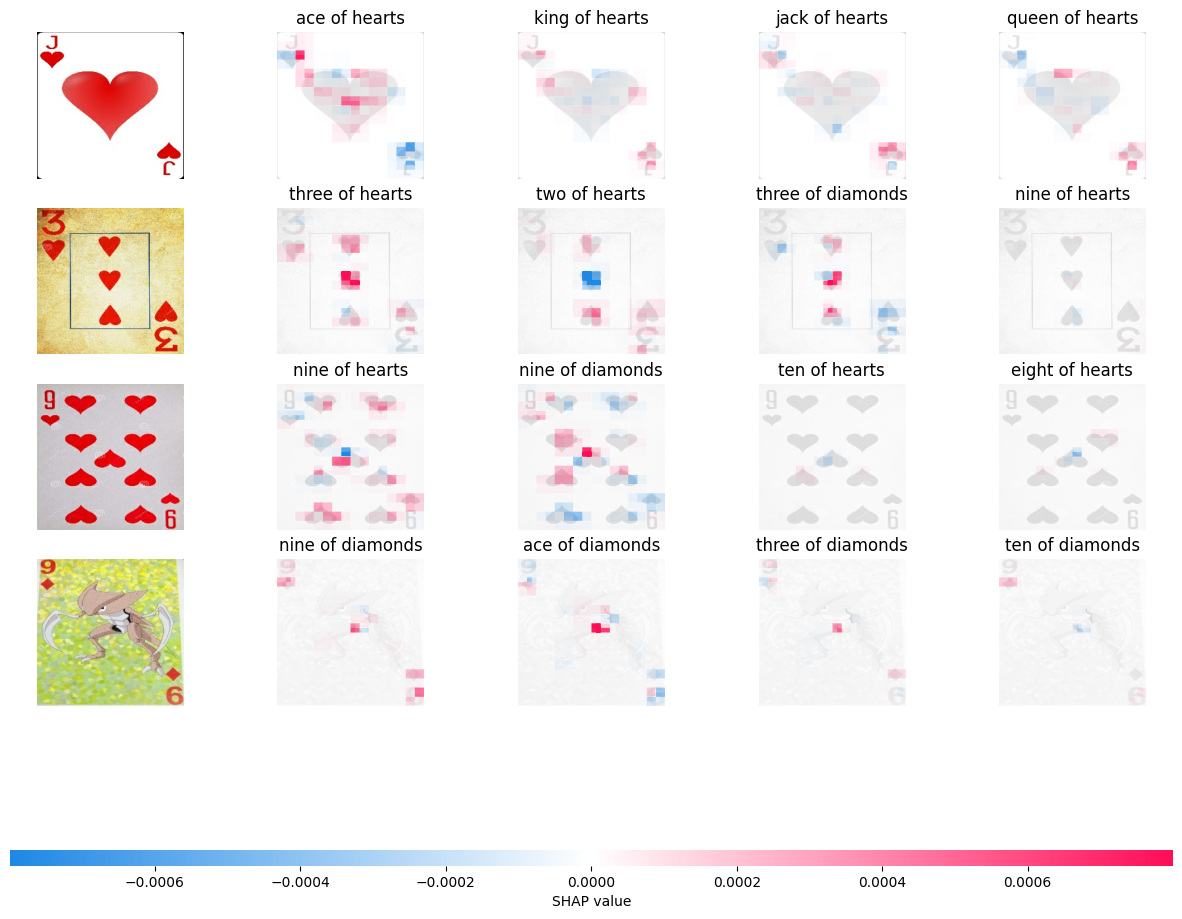

<Figure size 640x480 with 0 Axes>

In [ ]:
#SHAP plot

shap.image_plot(shap_values,inverse_transform(X[1:5]))

In [ ]:
#SHAP code using inpaint telea

def f(X):
    return model(X)
masker = shap.maskers.Image("inpaint_telea", X[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)
shap_values = explainer(X[1:5], max_evals=5000, batch_size=32, outputs=shap.Explanation.argsort.flip[:4])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██▌       | 1/4 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 3/4 [09:49<02:47, 167.46s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 4/4 [14:53<00:00, 224.03s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [18:55, 283.81s/it]


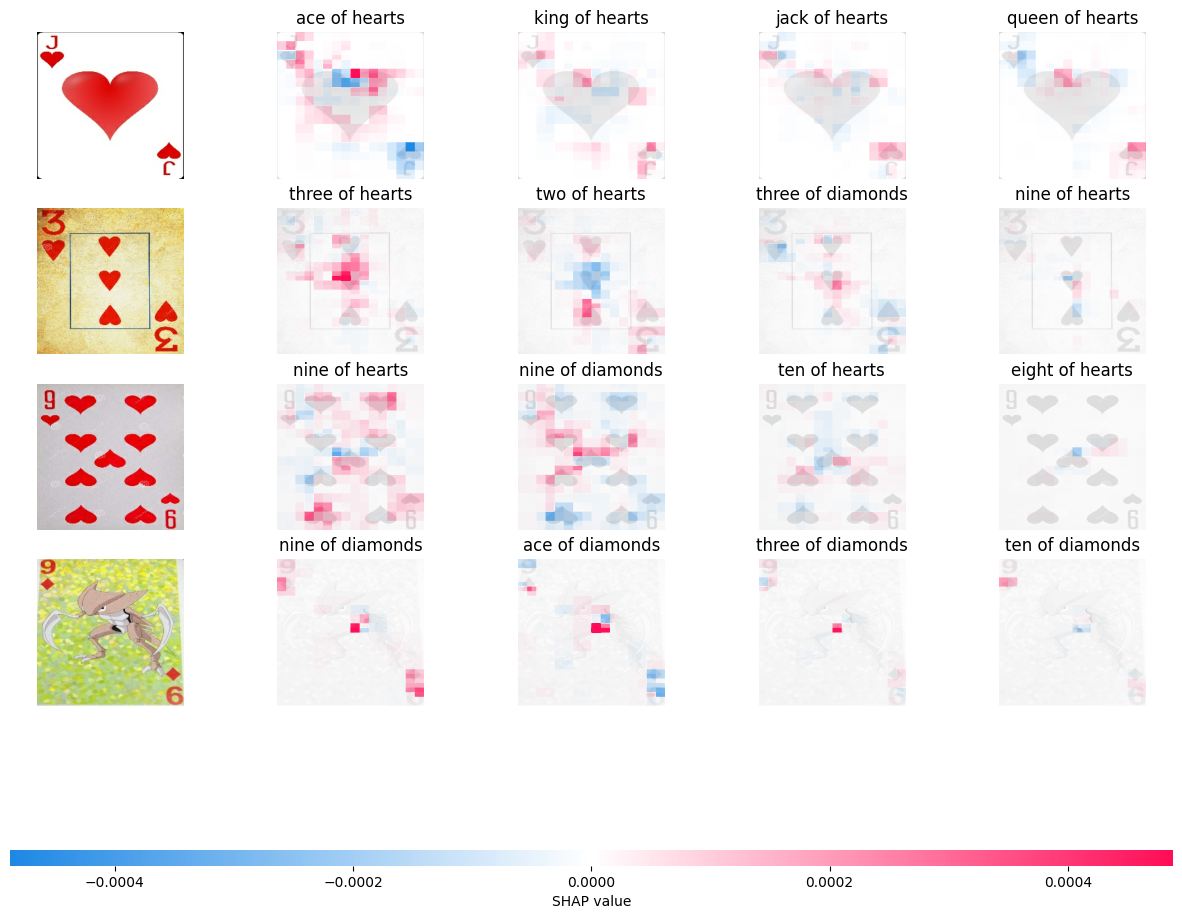

<Figure size 640x480 with 0 Axes>

In [ ]:
#SHAP plot

shap.image_plot(shap_values, inverse_transform(X[1:5]))

<ipython-input-60-8ded7abf3f20>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(sorted_class_names, rotation=90)


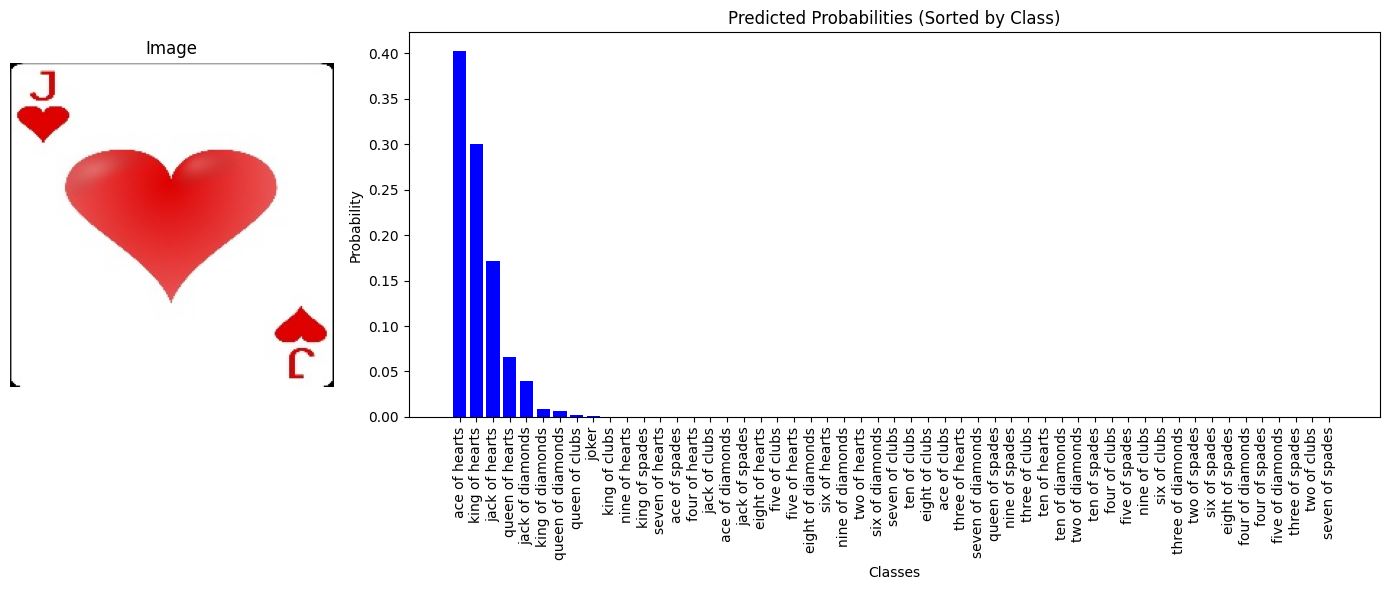

In [ ]:
#Compute probabilities for the first image

img_path = '/content/test/jack of hearts/2.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model(img_array)[0].numpy()

class_names = [label_to_class_name[i] for i in range(len(predictions))]
sorted_indices = np.argsort(predictions)[::-1]
sorted_predictions = predictions[sorted_indices]
sorted_class_names = np.array(class_names)[sorted_indices]

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(14, 6))
ax1.imshow(image.load_img(img_path))
ax1.axis('off')
ax1.set_title("Image")
ax2.bar(sorted_class_names, sorted_predictions, color='blue')
ax2.set_xticklabels(sorted_class_names, rotation=90)
ax2.set_xlabel('Classes')
ax2.set_ylabel('Probability')
ax2.set_title('Predicted Probabilities (Sorted by Class)')
plt.tight_layout()
plt.savefig('/content/predicted_probabilities1.png')
plt.show()

<ipython-input-52-7beaab7b755e>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(sorted_class_names, rotation=90)


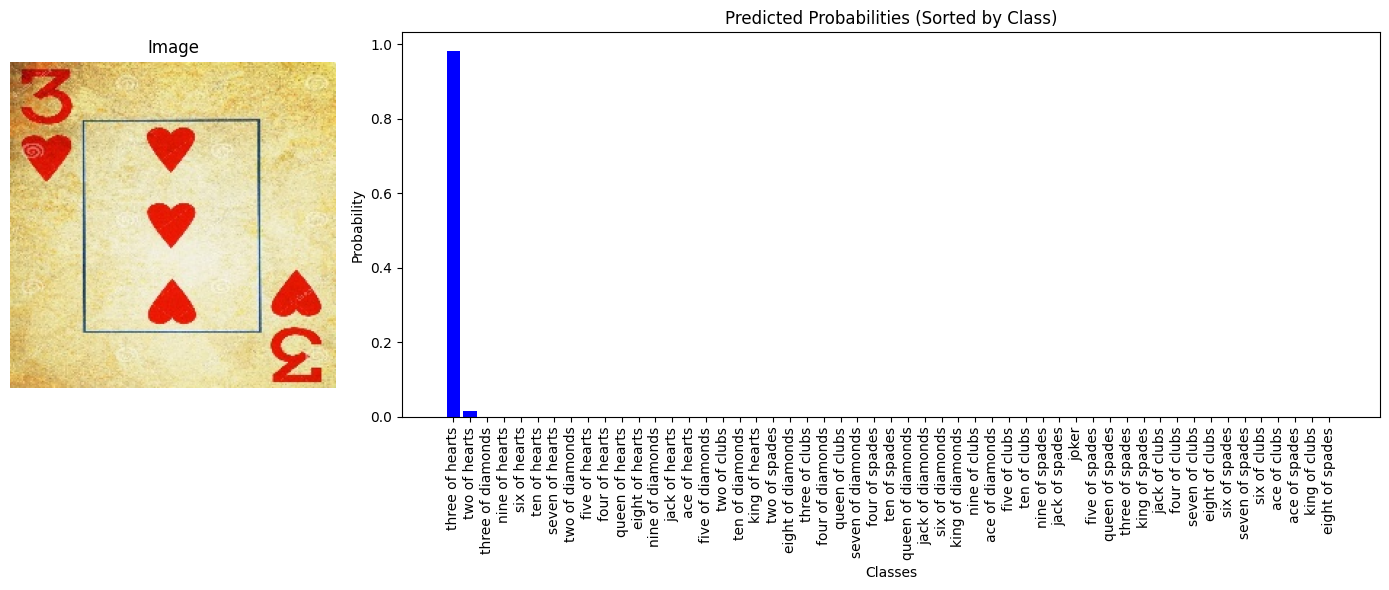

In [ ]:
#Compute probabilities for the second image

img_path = '/content/test/three of hearts/5.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model(img_array)[0].numpy()

class_names = [label_to_class_name[i] for i in range(len(predictions))]
sorted_indices = np.argsort(predictions)[::-1]
sorted_predictions = predictions[sorted_indices]
sorted_class_names = np.array(class_names)[sorted_indices]

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(14, 6))
ax1.imshow(image.load_img(img_path))
ax1.axis('off')
ax1.set_title("Image")
ax2.bar(sorted_class_names, sorted_predictions, color='blue')
ax2.set_xticklabels(sorted_class_names, rotation=90)
ax2.set_xlabel('Classes')
ax2.set_ylabel('Probability')
ax2.set_title('Predicted Probabilities (Sorted by Class)')
plt.tight_layout()
plt.savefig('/content/predicted_probabilities.png')
plt.show()

In [ ]:
#focusing on three of hearts

img_path = '/content/test/three of hearts/4.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

predictions = model(img_array)[0].numpy()

class_names = [label_to_class_name[i] for i in range(len(predictions))]
sorted_indices = np.argsort(predictions)[::-1]
sorted_predictions = predictions[sorted_indices]
sorted_class_names = np.array(class_names)[sorted_indices]

print(predictions)

[2.2884534e-17 9.3777839e-13 4.8675814e-09 3.4797296e-18 8.1401539e-16
 5.2655148e-11 2.9638999e-08 1.1940547e-19 1.9107960e-12 3.3648138e-09
 1.0826988e-07 2.5250254e-14 1.2918676e-14 2.9003102e-11 9.6046286e-08
 8.9586975e-12 1.3822653e-14 7.8838715e-12 9.4498045e-09 6.9215765e-14
 3.9512942e-14 2.2116651e-18 8.9650050e-12 7.1138845e-10 2.6901068e-14
 1.2498794e-12 2.0654801e-08 4.4771165e-05 1.6777945e-13 2.0271930e-11
 1.1463442e-11 7.4262012e-08 3.0821232e-14 9.6120293e-16 1.1895928e-11
 6.7581874e-07 4.8103139e-16 2.1392103e-16 7.4648551e-12 5.0237053e-05
 1.3200633e-15 8.5529137e-13 7.3440448e-10 5.4792662e-07 6.3211706e-12
 2.5381973e-11 1.4573050e-04 9.7521192e-01 1.1327430e-14 7.2022588e-10
 1.2970857e-07 2.4545623e-02 5.8301503e-11]


In [ ]:
#SHAP only respect to the label with the highest probability to get the Shapley Values and the Base Value

def f(X):
    return model(X)
masker = shap.maskers.Image("blur(128,128)", X[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)
shapley_values = explainer(img_array, max_evals=5000, batch_size=32, outputs=shap.Explanation.argsort.flip[0:1])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:53, 113.88s/it]              


In [ ]:
Shap_flatten = shapley_values.values.flatten()
phi_0 = shapley_values.base_values
print(phi_0)
print(sum(Shap_flatten))

[[0.01807631]]
0.9571356084202878


In [ ]:
#SHAP only respect to the label with the second highest probability to get the Shapley Values and the Base Value

def f(X):
    return model(X)
masker = shap.maskers.Image("blur(128,128)", X[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)
shapley_values1 = explainer(img_array, max_evals=5000, batch_size=32, outputs=shap.Explanation.argsort.flip[1:2])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:41, 101.01s/it]              


In [ ]:
Shap_flatten1 = shapley_values1.values.flatten()
phi_01 = shapley_values1.base_values
print(phi_01)
print(sum(Shap_flatten1))

[[0.02312797]]
0.0014176517725264075


In [ ]:
#SHAP only respect to the label with the third highest probability to get the Shapley Values and the Base Value

def f(X):
    return model(X)
masker = shap.maskers.Image("blur(128,128)", X[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)
shapley_values2 = explainer(img_array, max_evals=5000, batch_size=32, outputs=shap.Explanation.argsort.flip[2:3])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:37, 97.21s/it]               


In [ ]:
Shap_flatten2 = shapley_values2.values.flatten()
phi_02 = shapley_values2.base_values
print(phi_02)
print(sum(Shap_flatten2))

[[0.02970579]]
-0.029560058435819058


In [ ]:
#SHAP only respect to the label with the fourth highest probability to get the Shapley Values and the Base Value

def f(X):
    return model(X)
masker = shap.maskers.Image("blur(128,128)", X[0].shape)
explainer = shap.Explainer(f, masker, output_names=class_names)
shapley_values3 = explainer(img_array, max_evals=5000, batch_size=32, outputs=shap.Explanation.argsort.flip[3:4])

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:27, 87.15s/it]               


In [ ]:
Shap_flatten3 = shapley_values3.values.flatten()
phi_03 = shapley_values3.base_values
print(phi_03)
print(sum(Shap_flatten3))

[[0.02148071]]
-0.021430474123922065


In [ ]:
np.min(np.abs(shapley_values.values))

1.4530417588719587e-08

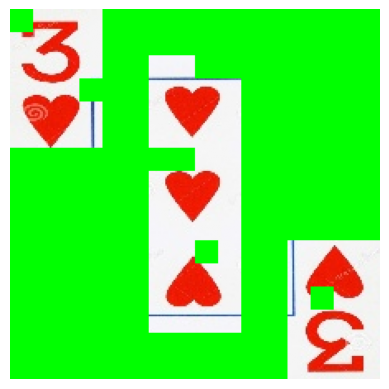

In [ ]:
#detecting the null Shapley Values

import numpy as np
shap_values = shapley_values.values
data = shapley_values.data

values = shap_values.squeeze(-1).squeeze(0)
image = data.squeeze(0)
threshold = 1e-7
mask = np.abs(values) < threshold

strange_color = np.array([0, 255, 0])
strange_color_array = np.tile(strange_color, (image.shape[0], image.shape[1], 1))

image_colored = np.where(mask, strange_color_array, image)

plt.imshow(inverse_transform(image_colored))
plt.axis('off')
plt.savefig('/content/image_colored.png')
plt.show()

